In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats

//anaconda/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.3.1 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [3]:
url = 'https://www.quandl.com/api/v3/datasets/BCHARTS/BTCCUSD.csv?api_key=dRQvv5_zYkkwzDssiLzH'


data = pd.read_csv(url)
data.index = data['Date']
del data['Date']
del data.index.name
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
2017-08-12,3600.00,4049.99,3600.0,3850.0,45.2332,170441.955545,3768.072026
2017-08-11,3385.00,3692.00,3385.0,3620.0,94.2659,332785.519453,3530.285283
2017-08-10,3345.01,3470.00,3337.0,3442.9,40.7009,138241.567918,3396.523613
2017-08-09,3417.00,3505.00,3242.0,3365.0,108.1564,367182.606553,3394.922599
2017-08-08,3399.97,3498.50,3350.0,3420.0,111.3431,381639.838445,3427.602056


In [4]:
data = data.reindex(index=data.index[::-1])
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
2017-04-12,1239.9,1239.9,1223.00,1230.0,89.4465,109903.068650,1228.701723
2017-04-13,1230.0,1233.9,1160.02,1183.0,370.4015,441422.023361,1191.739297
2017-04-14,1183.0,1218.0,1181.00,1207.0,129.5010,155690.996409,1202.237793
2017-04-15,1206.0,1215.0,1191.85,1192.0,159.5226,192173.690196,1204.680028
2017-04-16,1192.0,1213.0,1192.00,1213.0,74.9311,90195.815850,1203.716692


## Ichimoku Cloud Testing
  
  Lines Needed:  
  1) Conversion Line = (9-period high + 9-period low)/2))  
  2) Base Line = (26-period high + 26-period low)/2))  
  3) Leading Span A = (Conversion Line + Base Line)/2))  [midpoint of the conversion line and base line]  
  4) Leading Span B = (52-period high + 52-period low)/2))  
  5) Lagging Span = Close plotted 26 days in the past but on the current day

In [5]:
# Conversion Line

def find_rolling_highs_and_lows_line(high_data, low_data, window):
    '''
    Can be used to find conversion line or base line depending on the window size
    
    Inputs:
    high_data: pandas column from dataframe
    low_data: pandas column from dataframe
    window: int, window size
    
    Returns:
    line: 
    '''
    
    high = high_data.rolling(window=window).max()
    low = low_data.rolling(window=window).min()
    line = (high + low)/2
    return line.to_frame()

def find_span_A(conversion, base):
    span_A = (conversion['Conversion'] + base['Base'])/2
    return span_A.to_frame()

def find_ichimoku(data, convert_window, base_window, span_B_window, lagging_shift):
    high_data = data['High']
    low_data = data['Low']
    
    conversion = find_rolling_highs_and_lows_line(high_data, low_data, convert_window)
    conversion = conversion.rename(columns={0:'Conversion'})

    base = find_rolling_highs_and_lows_line(high_data, low_data, base_window)
    base = base.rename(columns={0:'Base'})

    span_B = find_rolling_highs_and_lows_line(high_data, low_data, span_B_window)
    span_B = span_B.rename(columns={0:'Span B'})

    span_A = find_span_A(conversion, base)
    span_A = span_A.rename(columns={0:'Span A'})

    lagging = data['Close'].shift(-lagging_shift).to_frame()
    lagging = lagging.rename(columns={'Close':'Lagging Close'})

    measures = [conversion, base, span_B, span_A, lagging]

    ichimoku = pd.concat(measures, axis=1)

    return ichimoku

params = [9, 26, 52, 22]   # [convert_window, base_window, span_B_window, lagging_shift]
ichimoku = find_ichimoku(data, *params)
ichimoku.tail()

,Conversion,Base,Span B,Span A,Lagging Close
2017-08-08,3078.250,2675.250,2675.250,2876.7500,NaN
2017-08-09,3081.500,2678.500,2678.500,2880.0000,NaN
2017-08-10,3102.500,2678.500,2678.500,2890.5000,NaN
2017-08-11,3198.575,2817.045,2772.000,3007.8100,NaN
2017-08-12,3405.030,3024.995,2950.995,3215.0125,NaN


In [ ]:
ichimoku.index = pd.to_datetime(ichimoku.index)
data.index = pd.to_datetime(data.index)

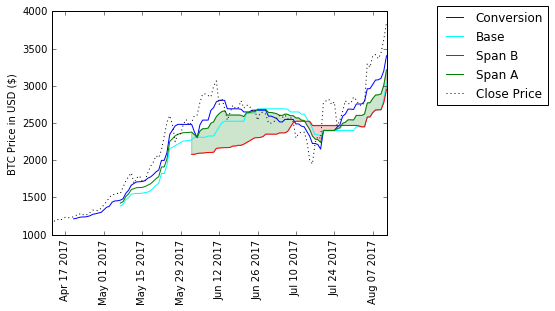

In [49]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='BTC Price in USD ($)')

colors = ['blue', 'cyan', 'red', 'green']
for col, color in zip(column_names, colors):
    if col != 'Lagging Close':
        ax1.plot(ichimoku.index, ichimoku[col], label=col, color=color)

ax1.plot(data.index, data.Close, linestyle=':', label="Close Price", color='k')

#fill the clouds

a = ichimoku['Span A']
b = ichimoku['Span B']

plt.fill_between(ichimoku.index, a, b, where=a >= b, facecolor='green', alpha='0.2', interpolate=True)
plt.fill_between(ichimoku.index, a, b, where=b >= a, facecolor='red', alpha='0.2', interpolate=True)

ax1.legend(bbox_to_anchor=(1.5, 1.05))
plt.xticks(rotation='vertical')
plt.show()